In [1]:
# deleting profile and radmass files
import os

# if os.path.exists('profileSL.dat'):
#     os.remove('profileSL.dat')

# if os.path.exists('radmassSL.dat'):
#     os.remove('radmassSL.dat')

In [2]:
# source: https://www.codesansar.com/numerical-methods/
#         runge-kutta-fourth-order-rk4-python-program.htm

import cmath #To help us out with the complex square root
import numpy as np #For the arrays
import matplotlib.pyplot as plt #Visualization

# define energy density as function of pressure

def eden(P):
    sqdoe = alpha**2 + 4*w*P + 12*w**2*B
    doeden = alpha**2/(2*w**2) + alpha/(2*w**2)*np.sqrt(sqdoe)
    lgPt = gamma*np.sqrt(P/w + 3*B + doeden)
    Ptilde = P - beta*(1+kappa*np.log(lgPt))
    sqde = alpha**2 + 4*w*Ptilde + 12*w**2*B
    deden = alpha**2/(2*w**2) + alpha/(2*w**2)*np.sqrt(sqde)
    # print("cek eden: ",sqdoe,doeden,lgPt,Ptilde,sqde,deden)
    return P/w + 4*B + deden

def dedP(P):
    dP = 0.00001
    x1 = P-2*dP
    x2 = P-dP
    x3 = P+dP
    x4 = P+2*dP
    dedP = eden(x1) - 8*eden(x2) + 8*eden(x3) - eden(x4)
    dedP = dedP/(12*dP)
    return dedP

# define tangential pressure

def fpt(ed,PCC):
    fpt = PCC + w*(ed-4*BT) - alphat*np.sqrt(ed-BT)
    fpt = fpt + betat*(1+kappat*np.log(gammat*np.sqrt(ed-BT)))
    fpt = fpt - w*(eden(PCC)-4*BT) + alphat*np.sqrt(eden(PCC)-BT)
    fpt = fpt - betat*(1+kappat*np.log(gammat*np.sqrt(eden(PCC)-BT)))
    return fpt

def dPTde(ed):
    return w-(1/2)*alphat/np.sqrt(ed-BT)+(1/2)*betat*kappat/(ed-BT)

# define sigma

def sig(P,PCC):
    ed = eden(P)
    Ptan = fpt(ed,PCC)
    sig = P - Ptan
    return sig

def dsdP(P,PCC):
    dP = 0.00001
    x1 = P-2*dP
    x2 = P-dP
    x3 = P+dP
    x4 = P+2*dP
    dsdP = sig(x1,PCC) - 8*sig(x2,PCC) + 8*sig(x3,PCC) - sig(x4,PCC)
    dsdP = dsdP/(12*dP)
    return dsdP


# the TOV SL equation

def b1(r,P,m,b,Lambda):
    Pcorr0 = Lambda - (1/2)*(eden(P)+P)**2 - 2*sig(P,PCC)*(eden(P)+P) 
    Pcorr = P - (KN/4)*ctilde*Pcorr0
    return (4*PI*r**3*Pcorr+MSS*m)*2*GS/(2*r*(r-2*GS*MSS*m))*2*b

def P1(r,P,m,b,Lambda):
    return -(eden(P)+P) * b1(r,P,m,b,Lambda)/(2*b) -2*sig(P,PCC)/r

def m1(r,P,m,b,Lambda):
    edencorr0 = Lambda - (3/2)*(eden(P)+P)**2 + 2*sig(P,PCC)*(eden(P)+P) 
    edencorr = eden(P) + (KN/4)*ctilde*edencorr0
    return 4*PI*r**2*edencorr/MSS

def L1(r,P,m,b,Lambda):
    ed = eden(P)
    dsde=1/dedP(P)-dPTde(ed)
    sigprime = dsdP(P,PCC)*P1(r,P,m,b,Lambda)
    sigprime = sigprime + dsde*dedP(P)*P1(r,P,m,b,Lambda)
    Lambda1 = P1(r,P,m,b,Lambda)*(eden(P)+P-2*sig(P,PCC))*(1-dedP(P))
    Lambda1 = Lambda1 + 8*sig(P,PCC)/r*(eden(P)+P-sig(P,PCC))
    Lambda1 = Lambda1 + 2*sigprime*(eden(P)+P)
    return Lambda1

In [3]:
# define the Runge-Kutta 4th order for the problem
# if we want to print the profile, set profile=1
# if we not, set profile=0
def RungeKutta(rCC,bCC,LCC,PCC,MCC,h,profile):
    # input initial values
    r0 = rCC
    b0 = bCC
    P0 = PCC
    m0 = MCC
    L0 = LCC
    while (P0 > 0.):
        if profile == 1:
            f0 = 1-2*GS*MSS*m0/r0
            print(r0/1000, b0, P0, m0, L0/1.e+6, f0, file=open('profileSL.dat', 'a'))
        # calculate k1
        r01 = r0
        b01 = b0
        P01 = P0
        m01 = m0
        L01 = L0
        k1_b = h * b1(r01,P01,m01,b01,L01)
        k1_P = h * P1(r01,P01,m01,b01,L01)
        k1_m = h * m1(r01,P01,m01,b01,L01)
        k1_L = h * L1(r01,P01,m01,b01,L01)
        # calculate k2
        r01 = r0 + h/2
        b01 = b0 + k1_b/2
        P01 = P0 + k1_P/2
        m01 = m0 + k1_m/2
        L01 = L0 + k1_L/2
        k2_b = h * b1(r01,P01,m01,b01,L01)
        k2_P = h * P1(r01,P01,m01,b01,L01)
        k2_m = h * m1(r01,P01,m01,b01,L01)
        k2_L = h * L1(r01,P01,m01,b01,L01)
        # calculate k3
        r01 = r0 + h/2
        b01 = b0 + k2_b/2
        P01 = P0 + k2_P/2
        m01 = m0 + k2_m/2
        L01 = L0 + k2_L/2
        k3_b = h * b1(r01,P01,m01,b01,L01)
        k3_P = h * P1(r01,P01,m01,b01,L01)
        k3_m = h * m1(r01,P01,m01,b01,L01)
        k3_L = h * L1(r01,P01,m01,b01,L01)
        # calculate k4
        r01 = r0 + h
        b01 = b0 + k3_b
        P01 = P0 + k3_P
        m01 = m0 + k3_m
        L01 = L0 + k3_L
        k4_b = h * b1(r01,P01,m01,b01,L01)
        k4_P = h * P1(r01,P01,m01,b01,L01)
        k4_m = h * m1(r01,P01,m01,b01,L01)
        k4_L = h * L1(r01,P01,m01,b01,L01)
        # calculate the next r0, P0, m0, and b0
        r0 = r0 + h
        b0 = b0 + (k1_b+2*k2_b+2*k3_b+k4_b)/6
        P0 = P0 + (k1_P+2*k2_P+2*k3_P+k4_P)/6
        m0 = m0 + (k1_m+2*k2_m+2*k3_m+k4_m)/6
        L0 = L0 + (k1_L+2*k2_L+2*k3_L+k4_L)/6
        f0 = 1-2*GS*MSS*m0/r0
        # print(P0)
    if profile == 1:
        f0 = 1-2*GS*MSS*m0/r0
        print(r0/1000, b0, P0, m0, L0/1.e+6, f0, file=open('profileSL.dat', 'a'))
    # the results at the surface
    output = np.array([r0,b0,P0,m0,L0,f0])
    return output


# define for a single PCC
def single_PCC(x,radmassdata,profile):
    # define initial parameters
    rCC = 1.*10**(-12) # radius near center in m--the starting point
    rmax = 100000. # radius at far distances in m
    PCC = x # pressure at the center in MeV / fm^3
    MCC = (4*PI/3)*eden(PCC)*rCC**3/MSS # Mass at the center in MeV m^3 / fm^3
    bCC = 1-2*GS*MSS*MCC/rCC # metric function b(r) at the center
    LCC = 1.*10**(-12) # Lambda function at center

    h = 10. # h-step

    # calculate the surface values
    output=RungeKutta(rCC,bCC,LCC,PCC,MCC,h,0)
    # print(output)

    # at the surface, b = 1-2Gm/r, which is different to the result
    rSurface=output[0]
    bSurface=output[1]
    mSurface=output[3]
    bSurfaceTarget = 1-2*GS*MSS*mSurface/rSurface

    # So, we redefine bCC as follows
    bCorrection=bSurfaceTarget/bSurface
    # print("cek bCC ",abs(bCorrection-1))

    # if abs(LSurface) not near 0, then recalculate
    LSurface=output[4]
    print(PCC, rSurface, mSurface, GS*MSS*mSurface/rSurface, bCorrection, LSurface)

    # if abs(bCorrection) not near 1, then recalculate
    while (abs(bCorrection-1)>10**(-3)):
        while (abs(LSurface)>10**(-1)):
            print("abs(LSurface)>10**(-1)")
            if ctilde==0:
                break
            LCC = LCC - LSurface
            output=RungeKutta(rCC,bCC,LCC,PCC,MCC,h,0)
            LSurface=output[4]
            # print("cek LCC ",(LSurface))
            # print(output)
        print("abs(bCorrection-1)>10**(-3)")
        bCC=bCC*bCorrection
        output=RungeKutta(rCC,bCC,LCC,PCC,MCC,h,0)
        rSurface=output[0]
        bSurface=output[1]
        mSurface=output[3]
        bSurfaceTarget = 1-2*GS*MSS*mSurface/rSurface
        bCorrection=bSurfaceTarget/bSurface

    rSurface=output[0]
    bSurface=output[1]
    mSurface=output[3]
    bSurfaceTarget = 1-2*GS*MSS*mSurface/rSurface
    bCorrection=bSurfaceTarget/bSurface
    LSurface=output[4]
    print(PCC, rSurface, mSurface, GS*MSS*mSurface/rSurface, bCorrection, LSurface)

    if profile == 1:
        output=RungeKutta(rCC,bCC,LCC,PCC,MCC,h,profile)
        # print(output)
    if radmassdata == 1:
        print(PCC, (eden(PCC)/1000), (rSurface/1000), mSurface, 
            2*GS*MSS*mSurface/rSurface, LCC/1.e+6, 0.5*np.log(bCC),
            file=open('radmassSL.dat', 'a'))

    output2=np.array([PCC, (eden(PCC)/1000), (rSurface/1000), mSurface, GS*MSS*mSurface/rSurface])
    return output2

In [4]:
# some constants
GS = 1.325 * 10**(-12) # Newton constant in fm^3 / MeV m^2
MSS = 1.1155 * 10**(15) # Sun's mass in MeV m^3 / fm^3
PI = np.pi 
HC = 197.327 # hc=1=197.327 MeV fm
KN = 8*PI*GS

# constants in eden
B = 57 # MeV
w = 1. # speed of sound
a4 = 0.7 # don't know, dimensionless
ms = 100 # quark mass in MeV

# additional constants for tangential pressure
BT = 57 # MeV
a4t = 0.07 # don't know, dimensionless

# constants for SL model
ctilde = 1.e7 # meter^2

# masalah satuan 
alpha = ms**2/(3*PI*np.sqrt(a4))*HC**(-1.5)
beta = ms**4/(12*PI**2)*(1-1/a4)*HC**(-3)
gamma = 8*PI/(3*ms**2*np.sqrt(a4))*HC**(1.5)
kappa = 3/(1-1/a4)

alphat = ms**2/(3*PI*np.sqrt(a4t))*HC**(-1.5)
betat = ms**4/(12*PI**2)*(1-1/a4t)*HC**(-3)
gammat = 8*PI/(3*ms**2*np.sqrt(a4t))*HC**(1.5)
kappat = 3/(1-1/a4t)

In [4]:
# this is only for a single PCC & and just testing
PCC=500
output=single_PCC(PCC,0,0)

500 14420.0 3.4563770400958926 0.35427565044387876 0.05151163837523765 -76110.75511848342
abs(LSurface)>10**(-1)
abs(LSurface)>10**(-1)
abs(LSurface)>10**(-1)
abs(bCorrection-1)>10**(-3)
abs(bCorrection-1)>10**(-3)
500 14410.0 3.5252008694707215 0.36158078279738587 1.0000000000031588 0.00011317341991556873


In [41]:
# this is for multiple PCC
for x in range(5, 501, 5):
    PCC=x
    if PCC==500:
        single_PCC(PCC,1,1)
    else:
        single_PCC(PCC,1,0)

5 5540.000000000001 0.14620185446044798 0.03900574430723543 0.8828045410826179 -330.51473328888574
abs(LSurface)>10**(-1)
abs(bCorrection-1)>10**(-3)
5 5540.000000000001 0.14621978906702188 0.03901052914858272 0.999998816218024 0.06819074906730815
10 7460.000000000001 0.35966029401378896 0.07125890104737338 0.7875248958887238 -672.4819888212645
abs(LSurface)>10**(-1)
abs(LSurface)>10**(-1)
abs(bCorrection-1)>10**(-3)
10 7460.000000000001 0.3597508208837046 0.07127683698684964 0.999991369752673 -9.301156180629988e-05
15 8730.0 0.5806142023675338 0.09830121009528105 0.7089001390046383 -1028.9763822020589
abs(LSurface)>10**(-1)
abs(LSurface)>10**(-1)
abs(bCorrection-1)>10**(-3)
15 8730.0 0.5808390629558386 0.09833928024210656 0.9999732363754935 -0.0002629035029122484
20 9660.0 0.7922450246707639 0.1212182045188213 0.6432581743111424 -1389.39575361201
abs(LSurface)>10**(-1)
abs(LSurface)>10**(-1)
abs(bCorrection-1)>10**(-3)
abs(bCorrection-1)>10**(-3)
20 9670.0 0.7950520886689929 0.1215219

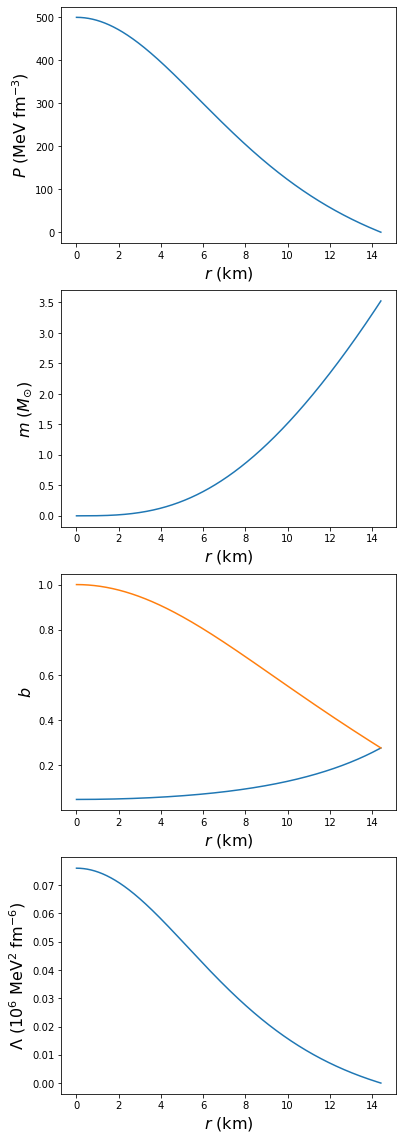

In [5]:
# plotting the profile from 1 PCC

profile=np.loadtxt("profileSL.dat")[:, :]
profr0=profile[:,0]
profb0=profile[:,1]
profP0=profile[:,2]
profm0=profile[:,3]
profL0=profile[:,4]
proff0=profile[:,5]

fig, ax = plt.subplots(4, 1, figsize = (6,20))

ax[0].plot(profr0, profP0)
ax[0].set_xlabel(r'$r$ (km)', fontsize=16)
ax[0].set_ylabel(r'$P$ (MeV fm$^{-3}$)', fontsize=16)

ax[1].plot(profr0, profm0)
ax[1].set_xlabel(r'$r$ (km)', fontsize=16)
ax[1].set_ylabel(r'$m$ ($M_{\odot}$)', fontsize=16)

ax[2].plot(profr0, profb0, profr0, proff0)
ax[2].set_xlabel(r'$r$ (km)', fontsize=16)
ax[2].set_ylabel(r'$b$', fontsize=16)

ax[3].plot(profr0, profL0)
ax[3].set_xlabel(r'$r$ (km)', fontsize=16)
ax[3].set_ylabel(r'$\Lambda$ (10$^6$ MeV$^2$ fm$^{-6}$)', fontsize=16)

plt.show()

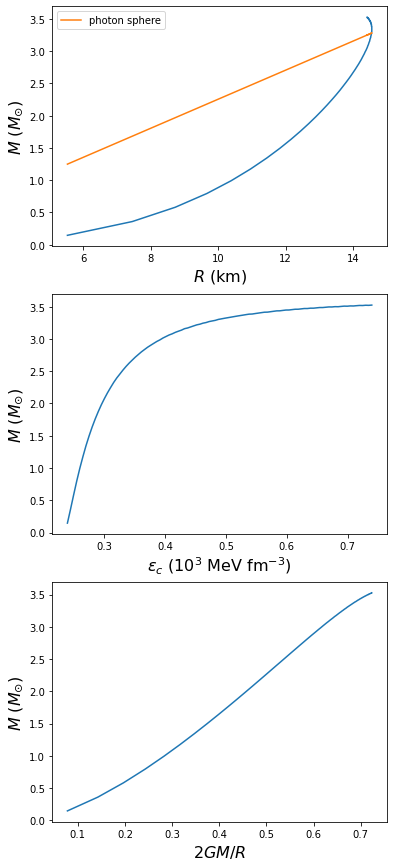

In [6]:
# plot all PCC

radmass=np.loadtxt("radmassSL.dat")[:, :]
dataEden=radmass[:,1]
dataRad=radmass[:,2]
dataMass=radmass[:,3]
dataCompactness=radmass[:,4]

fig, ax = plt.subplots(3, 1, figsize = (6,15))

x = dataRad
maxiter=len(x)-1
y = [0]*(maxiter+1)  # make arrays for photn sphere
for n in range(0, maxiter+1, 1):
    y[n] = x[n]*1.e3/(3*GS*MSS)

ax[0].plot(dataRad, dataMass)
ax[0].plot(x, y, label='photon sphere')
ax[0].set_xlabel(r'$R$ (km)', fontsize=16)
ax[0].set_ylabel(r'$M$ ($M_{\odot}$)', fontsize=16)
ax[0].legend()


ax[1].plot(dataEden, dataMass)
ax[1].set_xlabel(r'$\epsilon_c$ ($10^3$ MeV fm$^{-3}$)', fontsize=16)
ax[1].set_ylabel(r'$M$ ($M_{\odot}$)', fontsize=16)

ax[2].plot(dataCompactness, dataMass)
ax[2].set_xlabel(r'$2GM/R$', fontsize=16)
ax[2].set_ylabel(r'$M$ ($M_{\odot}$)', fontsize=16)

plt.show()

In [7]:
l = None

# effective potential outside the star in analytic form
def VeffOutside(r,mSurface,l):
    return (l*(l+1) - 6*GS*MSS*mSurface/r)*(1-2*GS*MSS*mSurface/r)/(r**2)*(GS*MSS*mSurface)**2
    
# effective potential inside the star in analytic form
def VeffInsideGR(r,mSurface,m,b,P,l):
    return (l*(l+1) - 6*GS*MSS*m/r + 4*PI*GS*r**2*( eden(P)-P ) )*b/(r**2)*(GS*MSS*mSurface)**2

def VeffInsideSL(r,mSurface,m,b,P,Lambda,l):
    corr = 2*PI*GS*ctilde*(2*Lambda - (eden(P)+P)**2)
    return (l*(l+1) - 6*GS*MSS*m/r + 4*PI*GS*r**2*( eden(P)-P + corr ) )*b/(r**2)*(GS*MSS*mSurface)**2

def rtortoise(r,m):  #definisi r tortoise
    return r + 2*GS*MSS*m*np.log( r/(2*GS*MSS*m)-1 )

In [8]:
# this is to calculate r tortoise outside the star numerically

# r-tortoise equation outside the star
def rtorOut1(r,mSurface):
    return 1./(1-2*GS*MSS*mSurface/r)

def RungeKuttaTortoise(rmax,rtormax,mSurface,rSurface,rCC,l,profile):
    # input initial values
    h = -10.
    r0 = rmax
    rtor0 = rtormax
    while (r0 > rCC):
        if profile == 1:
            VeffOut=VeffOutside(r0,mSurface,l)
            print(r0/1000, rtor0/1000, VeffOut, VeffOut, file=open('rtorSL.dat', 'a'))
        # calculate k1
        r01 = r0
        rtor01 = rtor0
        k1_rtor = h * rtorOut1(r01,mSurface)
        # calculate k2
        r01 = r0 + h/2
        rtor01 = rtor0 + k1_rtor/2
        k2_rtor = h * rtorOut1(r01,mSurface)
        # calculate k3
        r01 = r0 + h/2
        rtor01 = rtor0 + k2_rtor/2
        k3_rtor = h * rtorOut1(r01,mSurface)
        # calculate k4
        r01 = r0 + h
        rtor01 = rtor0 + k3_rtor
        k4_rtor = h * rtorOut1(r01,mSurface)
        # calculate the next r0, P0, m0, and b0
        r0 = r0 + h
        rtor0 = rtor0 + (k1_rtor+2*k2_rtor+2*k3_rtor+k4_rtor)/6
        if r0 < rSurface: #2*GS*MSS*mSurface:
            break
    # the results at the surface
    output2 = np.array([r0,rtor0])
    return output2

In [68]:
def integrate_inside(rtorSurface,l,profile):
    function = [0]*(maxdata+1)  # make arrays for r-tortoise equation inside the star
    for n in range(0, maxdata+1, 1):
        function[n] = 1/np.sqrt(profb0[n]*proff0[n])

    # calculate r-tortoise inside the star
    dr = (profr0[1]-profr0[0])
    for n in range(maxdata, 0, -1):
        rtorInt = rtorSurface - (dr/2)*(function[n] + 2 * sum(function[n+1:maxdata]) + function[maxdata])
        VeffInGR = VeffInsideGR(profr0[n],mSurface,profm0[n],profb0[n],profP0[n],l)
        VeffInSL = VeffInsideSL(profr0[n],mSurface,profm0[n],profb0[n],profP0[n],profL0[n],l)
        if profile == 1:
            print(profr0[n]/1000, rtorInt/1000, VeffInSL, VeffInGR, file=open('rtorSL_int.dat', 'a'))
            convert = 1.7827e12 # multiply with this to convert from MeV/fm^3 to g/cm^3
            correction_look = 2*PI*GS*ctilde*(2*profL0[n] - (eden(profP0[n])+profP0[n])**2)/(eden(profP0[n])-profP0[n])
            print(profr0[n]/1000, rtorInt/1000, profP0[n]*convert*1.e-15, eden(profP0[n])*convert*1.e-15, profb0[n], proff0[n], profL0[n]*(convert*1.e-15)**2, correction_look, file=open('rtorSL_input.dat', 'a'))
    # the result at the center
    output3 = np.array([profr0[0],rtorInt])
    return output3

In [69]:
profile=np.loadtxt("profileSL.dat")[:, :]
profr0=profile[:,0]*1000
profb0=profile[:,1]
profP0=profile[:,2]
profm0=profile[:,3]
profL0=profile[:,4]*1000000
proff0=profile[:,5]

maxdata=len(profr0)-1
rSurface=profr0[maxdata]
mSurface=profm0[maxdata]

In [70]:
l=None
l=2 # input

    
# calculate r tortoise outside the star
rmax = 100.e+3  # meter
rCC = profr0[0]
rmax2 = rmax + rCC
rtormax = rtortoise(rmax2,mSurface)
print(rmax2,rtormax)
if os.path.exists('rtorSL.dat'):
    os.remove('rtorSL.dat')
output2 = RungeKuttaTortoise(rmax2,rtormax,mSurface,rSurface,rCC,l,1)
print(output2)

# calculate r tortoise inside the star
if os.path.exists('rtorSL_int.dat'):
    os.remove('rtorSL_int.dat')
if os.path.exists('rtorSL_input.dat'):
    os.remove('rtorSL_input.dat')
rtorSurface = rtortoise(rSurface,mSurface)
print(rSurface,rtorSurface)
output3 = integrate_inside(rtorSurface,l,1)
print(output3)

100000.0 122418.42528868413
[14400.          4367.84769752]
14410.0 4404.002645065417
[ 1.00000000e-12 -5.35483445e+04]


In [82]:
profile=np.loadtxt("rtorSL_int.dat")[:, :]
r_int=profile[:,0]
rtor_int=profile[:,1]
VeffSL_int=profile[:,2]
VeffGR_int=profile[:,3]

profile=np.loadtxt("rtorSL.dat")[:, :]
r_out=profile[:,0]
rtor_out=profile[:,1]
VeffSL_out=profile[:,2]
VeffGR_out=profile[:,3]

profile=np.loadtxt("rtorSL_input.dat")[:, :]
# profr0[n]/1000, rtorInt/1000, profP0[n]*convert*1.e-15, eden(profP0[n])*convert*1.e-15, profb0[n], profm0[n], profL0[n]
r_out_2=profile[:,0]
rtor_out_2=profile[:,1]
Pres_out_2=profile[:,2]
eden_out_2=profile[:,3]
b_out_2=profile[:,4]
f_out_2=profile[:,5]
L_out_2=profile[:,6]
corr_out_2=profile[:,7]

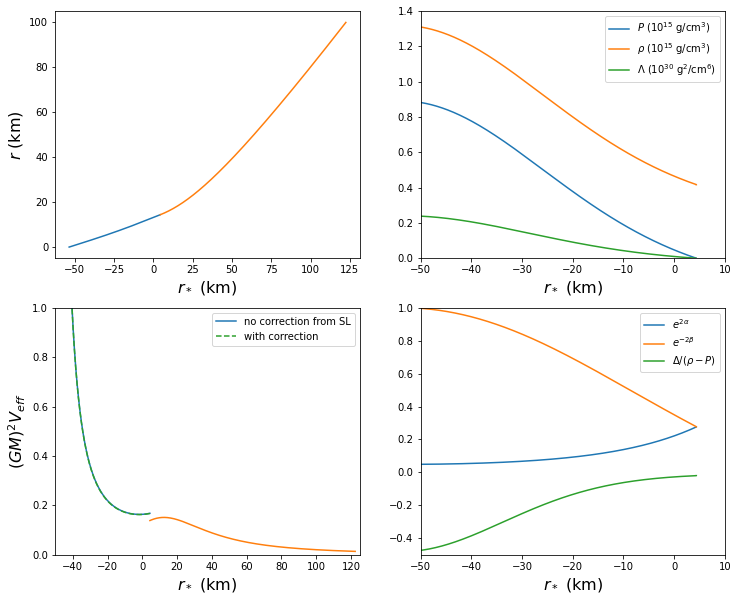

In [91]:
fig, ax = plt.subplots(2, 2, figsize = (12,10))

ax[0,0].plot(rtor_int, r_int)
ax[0,0].plot(rtor_out, r_out)
ax[0,0].set_xlabel(r'$r_*$ (km)', fontsize=16)
ax[0,0].set_ylabel(r'$r$ (km)', fontsize=16)
# ax[0,0].set_ylim([0,150])

ax[1,0].plot(rtor_int, VeffGR_int, label='no correction from SL')
ax[1,0].plot(rtor_out, VeffGR_out)
ax[1,0].plot(rtor_int, VeffSL_int, '--', label='with correction')
ax[1,0].set_xlabel(r'$r_*$ (km)', fontsize=16)
ax[1,0].set_ylabel(r'$(GM)^2 V_{eff}$', fontsize=16)
ax[1,0].set_ylim([0.,1.])
ax[1,0].set_xlim([-50,125])
ax[1,0].legend()

ax[0,1].plot(rtor_int, Pres_out_2, label=r'$P$ ($10^{15}$ g/cm$^3$)')
ax[0,1].plot(rtor_int, eden_out_2, label=r'$\rho$ ($10^{15}$ g/cm$^3$)')
ax[0,1].plot(rtor_int, L_out_2, label=r'$\Lambda$ ($10^{30}$ g$^2$/cm$^6$)')
ax[0,1].set_xlabel(r'$r_*$ (km)', fontsize=16)
# ax[0,1].set_ylabel(r'$P$ ($10^{15}$ g/cm$^3$)', fontsize=16)
ax[0,1].set_ylim([0.,1.4])
ax[0,1].set_xlim([-50,10])
ax[0,1].legend()

ax[1,1].plot(rtor_int, b_out_2, label=r'$e^{2\alpha}$')
ax[1,1].plot(rtor_int, f_out_2, label=r'$e^{-2\beta}$')
ax[1,1].plot(rtor_int, corr_out_2, label=r'$\Delta/(\rho-P)$')
ax[1,1].set_xlabel(r'$r_*$ (km)', fontsize=16)
# ax[1,1].set_ylabel(r'$\rho$ ($10^{15}$ g/cm$^3$)', fontsize=16)
ax[1,1].set_ylim([-.5,1.])
ax[1,1].set_xlim([-50,10])
ax[1,1].legend()


plt.show()

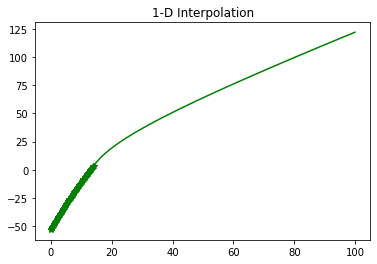

In [65]:
# hitung tau echo

# Import the required Python libraries
from scipy import interpolate
  
# Interpolation
temp_int = interpolate.interp1d(r_int, rtor_int)
xnew_int = np.arange(r_int[len(r_int)-1], r_int[0], 0.2)
ynew_int = temp_int(xnew_int)
  
# Interpolation
temp_out = interpolate.interp1d(r_out, rtor_out)
xnew_out = np.arange(r_out[len(r_out)-1], r_out[0], 0.2)
ynew_out = temp_out(xnew_out)
  
plt.title("1-D Interpolation")
plt.plot(xnew_int, ynew_int, '*', xnew_out, ynew_out, '-', color="green")
plt.show()

In [66]:
# calculate tau echo

# display r tortoise at faraway, light ring, surface from exterior data, surface from interior data, and the center
print(temp_out(r_out[0]),temp_out(3*GS*MSS*mSurface/1000),temp_out(r_out[len(r_out)-1]),temp_int(r_int[0]),temp_int(r_int[len(r_int)-1]))

# tau echo rumus approx yg integrasi dari permukaan ke photon sphere saja
def tauapp(r,m):
    return 4*GS*MSS*m*abs(np.log(r/(2*GS*MSS*m)-1)) 
tauapprox= tauapp(rSurface,mSurface) 
fapprox = PI/(tauapprox)*3.e8

# tau echo rumus numerik yg integrasi dari permukaan ke photon sphere
tauecho = 2* ( temp_out(3*GS*MSS*mSurface/1000) - temp_out(r_out[len(r_out)-1]) )*1000
fecho = PI/(tauecho)*3.e8

# tau echo rumus numerik yg integrasi dari pusat ke photon sphere
tauecho_0 = 2* ( temp_out(3*GS*MSS*mSurface/1000) - temp_int(r_int[len(r_int)-1]) )*1000
fecho_0 = PI/(tauecho_0)*3.e8

print(fapprox,fecho,fecho_0)
if os.path.exists('tauechoGR.dat'):
    os.remove('tauechoGR.dat')
print(fapprox,fecho,fecho_0, file=open('tauechoGR.dat', 'a'))



122.41842528868413 8.408016169761531 4.404002645064779 4.3678804930907456 -53.54834454976838
47095.644874028636 117691.63493876027 7605.980928604234


In [67]:
import numpy as np #For the arrays

epsilon = 1.e-6
GS = 1.325e-12 
MSS = 1.1155e15

apptau = GS*MSS*2.7
apptau = apptau*4*abs(np.log(epsilon))
print(apptau)
print(np.pi/apptau*3.e8)

apptau = (27*(epsilon+1)**2)/(16*np.sqrt(epsilon))*(np.arctan(np.sqrt(epsilon)) + np.arctan(3*np.sqrt(epsilon))) + (9*epsilon - 3)/4 +2*np.log((9*epsilon + 1)/4)
apptau = apptau*GS*MSS*2.7
print(apptau)
print(np.pi/apptau*3.e8)
apptau = None

print(46*2.7*10**3)
print(46*2.7*10**3*27/16)

220534.3010122249
4273.610915631186
12879.706052950914
73175.41193892414
124200.0
209587.5
